<a href="https://colab.research.google.com/github/jduell12/DS-Unit-2-Linear-Models/blob/master/C_214_guided_project_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

In [36]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

# Libraries for today's project
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Part 1: Sprint Challenge Practice

- Can I import a CSV file into a DataFrame?
- Can I create a scatter plot?
- Can I split a DataFrame into a target vector and feature matrix?
- Can I split a dataset into a training set and a test set?
- Can I establish the baseline mean absolute error for a regression problem?
- Can I combine transformers with a predictor using a pipeline?
- Can I build a linear regresion model and a ridge regression model?
- Can I evaluate a model using common metrics like mean absolute error, root mean squared error, and R^2?
- If given a feature matrix, can I use my model to create a list of predictions?
- Can I create a horizontal bar chart with the coefficients from a linear model?

# Part 2: Pipelines and Plotting

Let's revise [our work from yesterday](https://tinyurl.com/yb9cz6n5).

# Part 3: Logistic Regression

# I. Wrangle Data

In [37]:
def wrangle(filepath):
  df = pd.read_csv(filepath, index_col='PassengerId', dtype={'Pclass': 'object'})
  # drop high cardinality categorical columns 
  df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
  return df

df = wrangle(DATA_PATH + 'titanic/train.csv')
X_test = wrangle(DATA_PATH + 'titanic/test.csv')

In [38]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


In [39]:
df.shape

(891, 8)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(3)
memory usage: 62.6+ KB


In [41]:
df['Survived'].head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

In [42]:
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
892,3,male,34.5,0,0,7.8292,Q
893,3,female,47.0,1,0,7.0000,S
894,2,male,62.0,0,0,9.6875,Q
895,3,male,27.0,0,0,8.6625,S
896,3,female,22.0,1,1,12.2875,S


In [43]:
X_test.shape

(418, 7)

## II. Split Data

In [44]:
# split target vector from feature matrix
target = 'Survived'
y = df[target]
X = df.drop(columns=target)

In [45]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
1,3,male,22.0,1,0,7.2500,S
2,1,female,38.0,1,0,71.2833,C
3,3,female,26.0,0,0,7.9250,S
4,1,female,35.0,1,0,53.1000,S
5,3,male,35.0,0,0,8.0500,S


In [46]:
y.head()


PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

Since there's no time series component, we should do a randomized train-validation split.

In [47]:
# split our data into a TRAINING set and a VALIDATION set 
# test_size = validation set size (want to be 20%)
# random_state can be any integer to see the randomness so that it can be reproducable 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train) + len(X_val) == len(X)

True

## III. Establish our baseline

- This is a **classification problem**, so we look at the **majority class** to calculate baseline **accuracy score**.

In [48]:
y_train.value_counts(normalize=True)



0    0.623596
1    0.376404
Name: Survived, dtype: float64

In [49]:
# between 0 and 1, 1 is best and 0 is worst 
print('Baseline Accuracy Score:', y_train.value_counts(normalize=True).max())

Baseline Accuracy Score: 0.6235955056179775


## IV. Build Model

- Why would regular linear regression not work here?

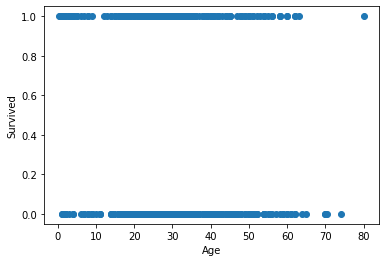

In [50]:
plt.scatter(X_train['Age'], y_train)
plt.xlabel('Age')
plt.ylabel('Survived');

# linear regression would not work because it would try to get between the two 
# lines which would always be around 0.4-0.6 and since survived is binary it 
# wouldn't be useful to determine if they survived or not 

What we need for our model pipeline:

- `OneHotEncoder`
- `SimpleImputer`
- `LogisticRegression`

In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 332 to 103
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    object 
 1   Sex       712 non-null    object 
 2   Age       572 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  710 non-null    object 
dtypes: float64(2), int64(2), object(3)
memory usage: 44.5+ KB


In [52]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,
332,1,male,45.5,0,0,28.5000,S
734,2,male,23.0,0,0,13.0000,S
383,3,male,32.0,0,0,7.9250,S
705,3,male,26.0,1,0,7.8542,S
814,3,female,6.0,4,2,31.2750,S


In [54]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True), # encode categorical features
    SimpleImputer(), # fill NaN values with column mean
    StandardScaler(), # rescales all features (mean = 0, std = 1)
    LogisticRegression()
)

model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Pclass', 'Sex', 'Embarked'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
    

## V. Check Metrics

In [55]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.8075842696629213
Validation Accuracy: 0.7988826815642458


## VI. Communicate Results

In [65]:
# model is a pipeline and need to go into pipline and get the logistic regressor
model.named_steps


{'logisticregression': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 'onehotencoder': OneHotEncoder(cols=['Pclass', 'Sex', 'Embarked'], drop_invariant=False,
               handle_missing='value', handle_unknown='value', return_df=True,
               use_cat_names=True, verbose=0),
 'simpleimputer': SimpleImputer(add_indicator=False, copy=True, fill_value=None,
               missing_values=nan, strategy='mean', verbose=0),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [67]:
coefficients = model['logisticregression'].coef_[0]
features = model['onehotencoder'].get_feature_names()

print(coefficients)
print(features)

[ 0.37784916  0.14961476 -0.44291577 -0.6377794   0.6377794  -0.39358277
 -0.34194212 -0.10584921  0.16634861 -0.11550991  0.08985349  0.02620068
  0.17703175]
['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Sex_female', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_S', 'Embarked_C', 'Embarked_Q', 'Embarked_nan']


In [68]:
feature_importance = pd.Series(coefficients, index=features).sort_values(key=abs)

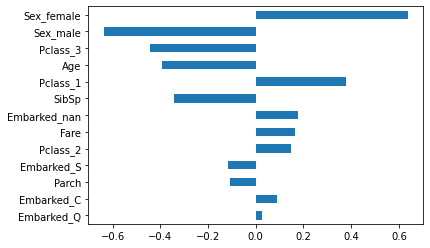

In [71]:
feature_importance.plot(kind='barh');

In [ ]:
# shows that being female, in first class are the top two reasons for surviving 
# as your age goes up your probability for surviving goes down

In [72]:
# predict the survivability that you would have to submit somewhere to check accuracy
model.predict(X_test)

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,